# PTST Idealization using axi-symmetric 2D interface layer

## Purpose of the notebook

Verify the axi-symmetric model in an elastic state to ensure that the confinement is
correctly reproduced. This notebook serves as a basis for 3D degradation within
a ligament/bond zone in axi-symmetric models. Examples are
 - PTST
 - prestressing
 - confined bond configuration
 - effect of splitting cracks
 - restrained splitting cracks in fatigue tests

## Implementation remarks

- The notebook now uses `BCSliceI` - to ensure the same order of nodes along an 
interfaces
- Compression is applied using individual `BCDof` instances without integration 
  over the boundary. This should be changed to BCSliceE - which can use the 
  finite element shape functions to integrate over the element domain

 - check the correctness of the wrapper interface  

In [1]:
%matplotlib widget
import time
from bmcs_expsim.utils.mlab_decorators import decorate_figure
from mayavi import mlab
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import warnings
import matplotlib.pylab as plt
import numpy as np
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.tmodel.mats3D.mats3D_elastic.vmats3D_elastic import \
    MATS3DElastic
from ibvpy.tmodel.mats2D.mats2D_elastic.vmats2D_elastic import \
    MATS2DElastic
from bmcs_matmod.slide.vslide_34_ij import MATS3DSlideStrain, Slide34
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from bmcs_matmod.ms1 import MS13D
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.mats3D.mats3D_microplane import \
    MATS3DMplCSDEEQ

## Simplified Ligament

In [66]:
CAxisymm = dict(E = 40e+3,    
                nu = 0.18,    
                Ad = 500.0,    
                eps_0 = 0.00001,    
                K_N = 17000.,    
                sigma_N_0 = 200., 
                gamma_N = 9000.,   
                sigma_T_0 = 3.0,   
                K_T = 200.0,  
                gamma_T = 5000,  
                S_T = 0.0007,  
                c_T = 2.9, 
                r_T = 3.,  
                m_T = 0.1, 
                p_T = 1.)


In [13]:
n_x_e = 4
n_inner_y_e = 2
n_outer_y_e = 2
L_x = 40.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 20
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [14]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [15]:
#w_max = 0.1
#
## Shear bc
#bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
#                  var='u', dims=[0,1,2], value=0.0)
#bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
#                 var='u', dims=[1], value=w_max)
#bc_r_x_2 = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
#                 var='u', dims=[0], value=0.0)

In [17]:
inner_fixed_1 = BCSliceI(slice=xmodel.mesh.I[:, 0], var='u', dims=[1], value=0)
inner_fixed_0 = BCSliceI(slice=xmodel.mesh.I[:, 0], var='u', dims=[0], value=0)

#outer_hoop = BCSliceI(slice=xmodel.mesh.I[:, -1], var='u', dims=[2], value=0)
#outer_hoop_dofs = outer_hoop.dofs

slide_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=-0.1)

slide_control_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=-0.1 , time_function=tf_sliding) 
                     for dof in slide_control_dofs ]


outer_compression_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=-5)

compression_dofs = outer_compression_slice.dofs
compression_stress = -15
compression_force = compression_stress  * 2 * np.pi* R_out * L_x / len(compression_dofs)
outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
# outer_compression_force_first = [BCDof(var='u', dof=dof, value=0.01, time_function=tf_precrompression) 
#                                  for dof in compression_dofs ]
outer_compression_force_first[0].value *=0.5
outer_compression_force_first[-1].value *=0.5

bc1 =   [inner_fixed_1, 
         inner_fixed_0,
        ]   + slide + outer_compression_force_first 
           

In [18]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

4070.4189277549767
4.070418927754977


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
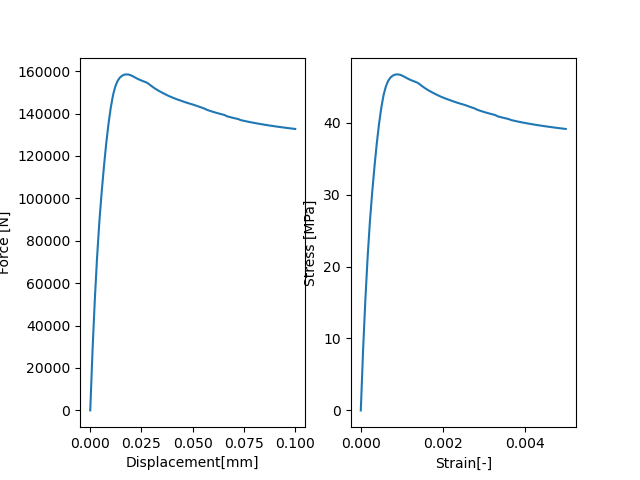

In [19]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, slide_control_dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, slide_control_dofs], axis=-1)
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(-U_t, -F_t)
ax1.set_ylabel('Force [N]')
ax1.set_xlabel('Displacement[mm]')
ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
ax2.set_ylabel('Stress [MPa]')
ax2.set_xlabel('Strain[-]')
G = np.trapz(F_t, x=U_t)/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x))*1000
G2 = np.trapz(F_t/(2 * np.pi * (R_in+dR)), x=U_t/(L_x-n_notch*2*d_x))
print(G)
print(G2)

In [20]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Complete representation

In [437]:
# CAxisymm = dict(
#     E = 40e+3,
#     nu = 0.18,
#     Ad = 3000.0,
#     eps_0 = 0.00001,
#     K_N = 17000.,
#     sigma_N_0 = 45.,
#     gamma_N = 9000.,
#     sigma_T_0 = 300.0,
#     K_T = 20000.0,
#     gamma_T = 50000,
#     S_T = 0.0075,
#     c_T = 2.,
#     r_T = 2.,
#     m_T = 0.1,
#     p_T = 1.
# )

# CAxisymm = dict(
#     E = 40e+3,
#     nu = 0.18,
#     Ad = 1802.0,
#     eps_0 = 0.0001,
#     K_N = 17000.,
#     sigma_N_0 = 45.,
#     gamma_N = 9000.,
#     sigma_T_0 = 2.0,
#     K_T = 20000.0,
#     gamma_T = 500000,
#     S_T = 0.0075,
#     c_T = 9.,
#     r_T = 5.,
#     m_T = 0.1,
#     p_T = 10.
# )

CAxisymm = dict(
    E = 40e+3,
    nu = 0.18,
    Ad = 500.0,
    eps_0 = 0.00001,
    K_N = 17000.,
    sigma_N_0 = 45.,
    gamma_N = 9000.,
    sigma_T_0 = 0.8,
    K_T = 100.0,
    gamma_T = 100,
    S_T = 0.00001,
    c_T = 1.6,
    r_T = 2.,
    m_T = 0.1,
    p_T = 1.
)

CAxisymmMDM = dict(
    epsilon_0 = 59.0e-6,
    epsilon_f = 250.0e-6,
    c_T = 0.02,
    E = 40000,
    nu = 0.18
)

In [438]:
n_x_e = 4
n_inner_y_e = 2
n_outer_y_e = 2
L_x = 40.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 20
n_notch = 1
# geo_transform
# gmesh
xd_inner = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, 0),
                               coord_max=(L_x, R_in),
                               shape=(n_x_e, n_inner_y_e),
                               fets=FETS2D4Q())
xd_middle = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())
xd_outer = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, R_in+dR),
                               coord_max=(L_x, R_out),
                               shape=(n_x_e, n_outer_y_e),
                               fets=FETS2D4Q())
m_elastic = MATS3DElastic(E=40000, nu=0.18)
# m_elastic = MATS3DMplDamageEEQ(**CAxisymmMDM)
# m_elastic = MS13D(**CAxisymm)


# m_inelastic = MATS3DElastic(E=37000, nu=0.18)
n_i = [0,1,0]
E = 37000
nu = 0.18
#material_params =  dict(
#     E_T=get_E_T(E,nu,n_i), gamma_T=10000, K_T=0, S_T=0.005, c_T=6, bartau=6, 
#     E_N=E, S_N=0.5, c_N = 3, m = 0.1, f_t=4, f_c=100, f_c0 = 80, eta=0.)
#bond_m = Slide34(**material_params)
m_inelastic = MS13D(**CAxisymm)
# m_inelastic = MATS3DMplDamageEEQ(**CAxisymmMDM)
# m_inelastic = Debugging(slide_displ=bond_m)
m = TStepBC(
    domains=[(xd_inner, m_elastic),
             (xd_outer, m_elastic),
             (xd_middle, m_inelastic),
             ]
)

## Boundary and transition conditions

In [439]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

### Kinematic links between the domains

In [440]:
# xd_inner.mesh.dofs

In [441]:
# xd_outer.mesh.dofs

In [442]:
# xd_middle.mesh.dofs

In [443]:
# xd_middle.mesh.I[:, -1].dofs

In [444]:
# xd_inner.mesh.I[:, -1].dofs

In [445]:
link_inner_middle_0 = BCSliceI(var='u', dims=[0],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_inner_middle_1 = BCSliceI(var='u', dims=[1],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

link_middle_outer_0 = BCSliceI(var='u', dims=[0],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_middle_outer_1 = BCSliceI(var='u', dims=[1],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

# link_middle_outer = BCSliceI(var='u', dims=[0, 1],
#                              slice=xd_middle.mesh.I[n_notch:-n_notch, 0], 
#                              # slice=xd_outer.mesh.I[:, 0], 
#                              link_slice=xd_outer.mesh.I[:, -1],
#                              link_coeffs=[1, 1],
#                              link_dims=[0, 1],
#                              value=0,
#                             )

In [446]:
link_middle_outer_0.dofs

array([36, 42, 48])

### Compression/Traction fc

In [447]:
# inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
# outer_fixed_0 = BCSliceI(slice=xd_outer.mesh.I[0, :], var='u', dims=[0], value=0)

# outer_compression_slice = BCSliceI(slice=xd_outer.mesh.I[:, -1],
#                                    var='u', dims=[1], value=-0.6)

# compression_dofs = outer_compression_slice.dofs
# compression_stress = -10
# compression_force = compression_stress  * 2*np.pi*R_out * L_x / len(compression_dofs)
# outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force) 
#                                  for dof in compression_dofs ]
# # outer_compression_force_first[0].value *=0.5
# # outer_compression_force_first[-1].value *=0.5
# bc1 = [inner_fixed_1, 
# #       outer_fixed_0,
#        link_inner_middle,
#        link_middle_outer,
#       outer_compression_slice] #+ outer_compression_force_first

### Sliding dc

In [448]:
# inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
# inner_fixed_0 = BCSliceI(slice=xd_inner.mesh.I[0, :], var='u', dims=[0], value=0)
# inner_outer_1 = BCSliceI(slice=xd_outer.mesh.I[:, 0], var='u', dims=[1], value=0)

# outer_slide_slice = BCSliceI(slice=xd_outer.mesh.I[0, :],
#                                    var='u', dims=[0], value=-0.1)


# bc1 =   [inner_fixed_1, 
#         inner_fixed_0,
#          inner_outer_1,
#         link_inner_middle,
#         link_middle_outer,
#         outer_slide_slice]

## Sliding dc + Precompression fc

In [449]:
# inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
# inner_fixed_0 = BCSliceI(slice=xd_inner.mesh.I[0, :], var='u', dims=[0], value=0)
# outer_fixed_1 = BCSliceI(slice=xd_outer.mesh.I[:, -1], var='u', dims=[1], value=0)

# outer_slide_slice = BCSliceI(slice=xd_outer.mesh.I[-1, :],
#                                    var='u', dims=[0], value=-0.1)

# slide_control_dofs = outer_slide_slice.dofs
# outer_slide = [BCDof(var='u', dof=dof, value=-0.1 , time_function=tf_sliding) 
#                      for dof in slide_control_dofs ]


# outer_compression_slice = BCSliceI(slice=xd_outer.mesh.I[:, -1],
#                                    var='u', dims=[1], value=-5)

# compression_dofs = outer_compression_slice.dofs
# compression_stress = -5
# compression_force = compression_stress  * 2* np.pi* R_out * L_x / len(compression_dofs)
# outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
#                                  for dof in compression_dofs ]
# # outer_compression_force_first = [BCDof(var='u', dof=dof, value=0.01, time_function=tf_precrompression) 
# #                                  for dof in compression_dofs ]
# outer_compression_force_first[0].value *=0.5
# outer_compression_force_first[-1].value *=0.5

# bc1 =   [inner_fixed_1, 
#         # outer_fixed_1,
#          inner_fixed_0,
#         link_middle_outer_0,
#          link_middle_outer_1,
#         link_inner_middle_0,
#          link_inner_middle_1
#         ] + outer_compression_force_first + outer_slide

In [450]:
inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
outer_fixed_0 = BCSliceI(slice=xd_outer.mesh.I[0, :], var='u', dims=[0], value=0)
inner_fixed_out_1 = BCSliceI(slice=xd_inner.mesh.I[:, -1], var='u', dims=[1], value=0)


inner_slide_slice = BCSliceI(slice=xd_inner.mesh.I[-1, :],
                                   var='u', dims=[0], value=-0.1)

slide_control_dofs = inner_slide_slice.dofs
inner_slide = [BCDof(var='u', dof=dof, value=-0.5 , time_function=tf_sliding) 
                     for dof in slide_control_dofs ]


outer_compression_slice = BCSliceI(slice=xd_outer.mesh.I[:, -1],
                                   var='u', dims=[1], value=-5)

compression_dofs = outer_compression_slice.dofs
compression_stress = -15
compression_force = compression_stress  * 2* np.pi* R_out * L_x / len(compression_dofs)
outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]

compression_dofs_inner = inner_fixed_out_1.dofs
outer_compression_force_inner_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs_inner ]


# outer_compression_force_first = [BCDof(var='u', dof=dof, value=0.01, time_function=tf_precrompression) 
#                                  for dof in compression_dofs ]
outer_compression_force_first[0].value *=0.5
outer_compression_force_first[-1].value *=0.5
outer_compression_force_inner_first[0].value *=0.5
outer_compression_force_inner_first[-1].value *=0.5

bc1 =   [inner_fixed_1,
        outer_fixed_0,
        link_middle_outer_0,
         link_middle_outer_1,
        link_inner_middle_0,
         link_inner_middle_1
        ] + outer_compression_force_first + inner_slide

In [451]:
compression_dofs

array([35, 41, 47, 53, 59])

### Sliding fc

In [452]:
#lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
#upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#
#
#
#lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#Force = 10 / len(lower_slide.dofs)
#lower_slide_force = [BCDof(var='f', dof=dof, value = Force) 
#             for dof in lower_slide.dofs]
#
#bc1 =   [lower_fixed_0, upper_fixed_1] + lower_slide_force

In [453]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 500
s.tline.step = 0.02
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains

In [454]:
s.reset()
s.run()

t:	 0.00(0), 
	 0.02(1), 
	 0.04(8), 
	 0.06(9), 
	 0.08(10), 
	 0.10(11), 
	 0.12(25), 
	 0.14(34), 
	 0.16(48), 
	 0.18(89), 
	 0.20(69), 
	 0.22(79), 
	 0.24(108), 
	 0.26(43), 
	 0.28(43), 
	 0.30(43), 
	 0.32(43), 
	 0.34(43), 
	 0.36(43), 
	 0.38(43), 
	 0.40(43), 
	 0.42(43), 
	 0.44(43), 
	 0.46(43), 
	 0.48(43), 
	 0.50(43), 
	 0.52(43), 
	 0.54(43), 
	 0.56(43), 
	 0.58(43), 
	 0.60(43), 
	 0.62(43), 
	 0.64(43), 
	 0.66(43), 
	 0.68(43), 
	 0.70(43), 
	 0.72(43), 
	 0.74(43), 
	 0.76(43), 
	 0.78(43), 
	 0.80(43), 
	 0.82(43), 
	 0.84(43), 
	 0.86(43), 
	 0.88(43), 
	 0.90(43), 
	 0.92(43), 
	 0.94(43), 
	 0.96(43), 
	 0.98(43), 
	 1.00(43), 



## Postprocesing

### Access the last displacement step

In [455]:
F = m.hist.F_t
U = m.hist.U_t

In [456]:
F_slide = np.sum(F[:, slide_control_dofs], axis=-1)
U_slide = np.average(U[:, slide_control_dofs], axis=-1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
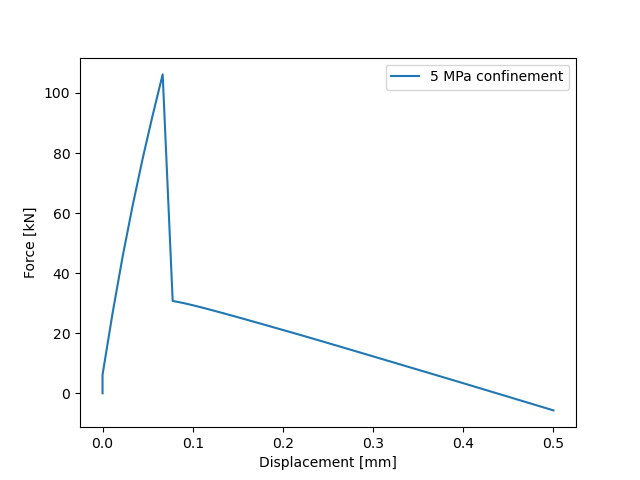

In [457]:
_, ax = plt.subplots(1,1)
ax.plot(-U_slide, -F_slide/1000, label='5 MPa confinement')
# ax.plot(-U_slide_2, -F_slide_2/1000, label='15 MPa confinement')
# ax.plot(-U_slide_3, -F_slide_3/1000, label='30 MPa confinement')
ax.set_ylabel('Force [kN]')
ax.set_xlabel('Displacement [mm]')
ax.legend()

In [415]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [196]:
eps_Emab = xd_middle.map_U_to_field(U[0])
m.fe_domain[2].state_k
m_inelastic.get_corr_pred(eps_Emab, 1, **m.fe_domain[2].state_k)

(array([[[[ 87.54205043, -58.43133525,   0.        ],
          [-58.43133525,  86.9735946 ,   0.        ],
          [  0.        ,   0.        ,  73.6923878 ]],
 
         [[ 80.51725183, -53.49966043,   0.        ],
          [-53.49966043,  78.91991024,   0.        ],
          [  0.        ,   0.        ,  66.20997599]],
 
         [[ 81.74790859, -54.1114823 ,   0.        ],
          [-54.1114823 ,  79.42887773,   0.        ],
          [  0.        ,   0.        ,  66.59926931]],
 
         [[ 88.65194107, -59.14893197,   0.        ],
          [-59.14893197,  87.97740625,   0.        ],
          [  0.        ,   0.        ,  74.51607799]]],
 
 
        [[[ 87.27258244, -57.6248956 ,   0.        ],
          [-57.6248956 ,  84.55000276,   0.        ],
          [  0.        ,   0.        ,  71.47880882]],
 
         [[100.66539581, -67.15461593,   0.        ],
          [-67.15461593,  99.90376747,   0.        ],
          [  0.        ,   0.        ,  85.07737923]],
 
       

In [170]:
m.fe_domain[2].state_k

{'omega_N_Emn': array([[[0.99876099, 0.99876099, 0.        , ..., 0.99943115,
          0.        , 0.        ],
         [0.9999    , 0.9999    , 0.        , ..., 0.9999    ,
          0.        , 0.        ],
         [0.9999    , 0.9999    , 0.        , ..., 0.9999    ,
          0.        , 0.        ],
         [0.99908783, 0.99908783, 0.        , ..., 0.99957753,
          0.        , 0.        ]],
 
        [[0.99971454, 0.99971454, 0.        , ..., 0.99986596,
          0.        , 0.        ],
         [0.99808771, 0.99808771, 0.        , ..., 0.9991293 ,
          0.        , 0.        ],
         [0.99782255, 0.99782255, 0.        , ..., 0.99901062,
          0.        , 0.        ],
         [0.99970022, 0.99970022, 0.        , ..., 0.99985921,
          0.        , 0.        ]],
 
        [[0.99940907, 0.99940907, 0.        , ..., 0.99972387,
          0.        , 0.        ],
         [0.991545  , 0.991545  , 0.        , ..., 0.99632315,
          0.        , 0.        ],

## Dissipative plane

In [2]:
from bmcs_matmod.slide.vslide_34_ij import MATS3DSlideStrain
class Debugging(MATS3DSlideStrain):
    def get_corr_pred(self, eps_Emab_n1, tn1, **state):
        n_i = self.n_a
        eps_ij = eps_Emab_n1
        eps_N = np.einsum('...ij,...i,...j->...', eps_ij, n_i, n_i)

        eps_T_Ema = self.get_eps_T(eps_ij, n_i)
        
        eps_NT_Ema = np.zeros_like(eps_T_Ema)
        eps_NT_Ema[..., 0] = eps_N
        eps_NT_Ema[..., 1] = eps_T_Ema[...,0]
        
        se = self.slide_displ
        sig_NT_Ema, D_Emab = se.get_corr_pred(eps_NT_Ema, tn1, **state)
        # sig_NT_Ema[...,0] = np.clip(sig_NT_Ema[...,0], 0, 2)
        # print(eps_NT_Ema)
        # print(sig_NT_Ema)
        eps_N_p, eps_T_p_x, eps_T_p_y = state['w_pi'], state['s_pi_x'], state['s_pi_y']
        eps_T = self.get_eps_T(eps_ij, n_i)
        eps_T_p_i = self.get_eps_T_p(eps_T_p_x, eps_T)
        omega_N_Em, omega_T_Em = state['omega_N'], state['omega_T']
        phi_Emab = np.zeros_like(eps_Emab_n1)


        phi_Emab[..., 1, 1] = np.sqrt(1 - omega_N_Em)
        phi_Emab[..., 0, 0] = np.sqrt(1 - omega_T_Em)

        phi_Emab[..., 2, 2] = 1



        beta_Emijkl = np.einsum('...ik,...lj->...ijkl', phi_Emab, phi_Emab)

        eps_ij_p = (np.einsum('i,...j->...ij', n_i, eps_T_p_i) +
                    np.einsum('...i,j->...ij', eps_T_p_i,n_i) +
                    np.einsum('...,i,j->...ij', eps_N_p, n_i, n_i)
                   )

        D_abef = self.D_abef
        D_Emabcd = np.einsum('...ijkl,klrs,...rstu->...ijtu', beta_Emijkl, D_abef, beta_Emijkl)

        sigma_Emab = np.einsum('...ijkl,...kl->...ij', D_Emabcd, (eps_Emab_n1 - eps_ij_p))
        # E = 37000
        # nu = 0.18
        # E_T = self.get_E_T( E, nu, n_i)
        # # sigma_Emab = (np.einsum( '...ijkl,...kl->...ij',D_abef, eps_ij) 
        # #         - np.einsum( '...,...i,...j->...ij', eps_N, n_i, n_i) * E 
        # #         + np.einsum( '...,...i,...j,...->...ij', (eps_N - eps_N_p) , n_i, n_i, (1-omega_N_Em)* E)
        # #         - E_T*(np.einsum('...i,...j->...ij', n_i, eps_T_Ema) + np.einsum('...i,...j->...ij', eps_T_Ema, n_i))
        # #         + (np.einsum('...,...i,...j->...ij', (1 - omega_T_Em)*E_T, n_i, (eps_T_Ema - eps_T_p_i)) + np.einsum('...,...i,...j->...ij', (1 - omega_T_Em)*E_T, (eps_T_Ema - eps_T_p_i), n_i)) 
        # #        )  
        # # print(sigma_Emab)
        # sigma_Emab  = np.einsum( '...ijkl,...kl->...ij',D_abef, (eps_ij - eps_ij_p)) 
        # sigma_Emab[...,1,1] = sig_NT_Ema[...,0]
        # sigma_Emab[...,0,1] = sigma_Emab[...,1,0] = sig_NT_Ema[...,1]
        
        # print(D_Emabcd)
                  

        return sigma_Emab, D_Emabcd

## FE Axisymmetric discretization

In [3]:
def get_D_ijkl(E,nu):
    delta_ij = np.identity(3)
    la = E * nu / ((1. + nu) * (1. - 2. * nu))
    mu = E / (2. + 2.* nu)
    D_ijkl = (np.einsum(',ij,kl->ijkl', la, delta_ij, delta_ij) +
              np.einsum(',ik,jl->ijkl', mu, delta_ij, delta_ij) +
              np.einsum(',il,jk->ijkl', mu, delta_ij, delta_ij))
    return D_ijkl

In [4]:
def get_E_T(E,nu,n_i):
    delta_ij = np.identity(3)
    D_ijkl = get_D_ijkl(E,nu)
    operator = 0.5*(np.einsum('i,jk,l->ijkl',n_i,delta_ij,n_i) 
                 + np.einsum('j,ik,l->jikl',n_i,delta_ij,n_i) 
                 - 2*np.einsum('i,j,k,l->ijkl',n_i,n_i,n_i,n_i))
    E_T = np.einsum('ijkl,ijkl->', D_ijkl, operator)
    return E_T